## Instalação Bibliotecas

In [1]:
#MapClin 24/01/22
#Necessario 4GB de RAM livres (computador com 8GB sem mais nada rodando)

#!pip install click==7.0
#!pip install Exit
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
##import sys
##!{sys.executable} -m conda install -c conda-forge spacy-model-pt_core_news_sm
#!pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
import unidecode
import nltk
import re
import unicodedata
#nltk.download('stopwords')
from nltk.corpus import stopwords
import string
#!pip install snowballstemmer
import snowballstemmer
import stanza
#stanza.download('pt')
from dicio import Dicio
#https://github.com/felipemfp/dicio
import pandas as pd
import numpy as np
import datetime
import collections
from collections import deque
from operator import itemgetter
import pickle
import os
import json
import matplotlib.pyplot as plt

## Funções e Classes

### Funções e Classes de Suporte

In [2]:
def purge_dublicates(X):
    unique_X = []
    for i, row in enumerate(X):
        if row not in X[i + 1:]:
            unique_X.append(row)
    return unique_X

def levenshtein(source, target):
    if len(source) < len(target):
        return levenshtein(target, source)

    # So now we have len(source) >= len(target).
    if len(target) == 0:
        return len(source)

    # We call tuple() to force strings to be used as sequences
    # ('c', 'a', 't', 's') - numpy uses them as values by default.
    source = np.array(tuple(source))
    target = np.array(tuple(target))

    # We use a dynamic programming algorithm, but with the
    # added optimization that we only need the last two rows
    # of the matrix.
    previous_row = np.arange(target.size + 1)
    for s in source:
        # Insertion (target grows longer than source):
        current_row = previous_row + 1

        # Substitution or matching:
        # Target and source items are aligned, and either
        # are different (cost of 1), or are the same (cost of 0).
        current_row[1:] = np.minimum(
                current_row[1:],
                np.add(previous_row[:-1], target != s))

        # Deletion (target grows shorter than source):
        current_row[1:] = np.minimum(
                current_row[1:],
                current_row[0:-1] + 1)

        previous_row = current_row

    return previous_row[-1]


class FileManager:
    def open_xlsx_folder(self, folder_path):
        '''
        Leitura de arquivos xlsx (le todos os arquivos em uma pasta)
        Necessário fornecer o caminho da pasta
        '''
        paths = glob.glob(folder_path +"/*.xlsx")
        data = pd.DataFrame()   
        for path in paths:
            df = pd.read_excel(path)
            print('Path: ',path,'\nLen: ',len(df),'\n')
            data = data.append(df)
        data.reset_index(inplace = True)
        return data
    
    def open_xlsx(self, path):
        df = pd.read_excel(path)
    
        return df
    
    def open_txt(self, path, header):
        if header == True:
            df = pd.read_csv(path, delimiter = '\n')
        else:
            df = pd.read_csv(path, delimiter = '\n', header = None)
    
        return df


### Classe Pre-Processamento

In [3]:
class PreProcessamento:
    __instance = None
    def __init__(self):
        pass
    
    @classmethod
    def getInstance(cls):
        if not cls.__instance:
            cls.__instance = PreProcessamento()
            cls.__instance.lemmatizer = nltk.WordNetLemmatizer()
            cls.__instance.nlp = stanza.Pipeline('pt', processors='tokenize,mwt,pos,lemma', tokenize_pretokenized=True)
        return cls.__instance
    
    def separaTextoEmSentenças(self,texto): # NÂO tokenizado
        sent_tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')
        return sent_tokenizer.tokenize(texto)
    
    def tokeniza(self,sentenca): # NÂO tokenizado
        #return self.tokenizer.tokenize(texto)
        return nltk.tokenize.word_tokenize(sentenca, language='portuguese')
        
    def expandeAcronimo(self,texto): #tokenizado
        #quanto acronimo esta em minusculo ele não é expandido, 
        #porém colocar tudo para upper case faz com que não acronimos sejam expandidos, levando a erros! (como "da")
        import pickle
        acronimosDict = pickle.load(open("DefaultAcronymsNew.pkl", "rb"))
        newTexto = []
        for token in texto:
            if token in acronimosDict:
                expandido = self.tokeniza(acronimosDict[token])
                newTexto.extend(expandido)
            else:
                newTexto.append(token)
        return newTexto
    
    def removeALLspace(self,string): # NÂO tokenizado
        ns = ""
        for s in string:
            if s != " ":
                ns+=s
        return ns
    
    def normalizaAcento(self,text): # NÂO tokenizado    
        try:
            text = unicode(text, 'utf-8')
        except NameError: # unicode is a default on python 3 
            pass
    
        text = unicodedata.normalize('NFD', text)\
               .encode('ascii', 'ignore')\
               .decode("utf-8")

        novo_s = re.sub("Ã…|Ã€|Ã |Ãƒ|Ã‚|Ã„","A",text);
        novo_s=re.sub("Ã¥|Ã |Ã¡|Ã£|Ã¢|Ã¤","a",novo_s);
        novo_s=re.sub("Ã¨|Ã©|Ã«|Ãª","e",novo_s);
        novo_s=re.sub("Ãˆ|Ã‰|Ã‹|ÃŠ","E",novo_s);
        novo_s=re.sub("Ã¬|Ã­|Ã¯|Ã®","i",novo_s);
        novo_s=re.sub("ÃŒ|Ã |Ã |ÃŽ]","I",novo_s);
        novo_s=re.sub("Ã²|Ã³|Ã¶|Ã´|Ãµ","o",novo_s);
        novo_s=re.sub("Ã'|Ã\"|Ã-|Ã•","O",novo_s);
        novo_s=re.sub("Ã¹|Ãº|Ã¼|Ã»/","u",novo_s);
        novo_s=re.sub("Ã™|Ãš|Ãœ|Ã›/","U",novo_s);
        novo_s=re.sub("Ã½|Ã¿","y",novo_s);
        novo_s=re.sub("Ã |Å¸","Y",novo_s);
        novo_s=re.sub("Ã§","c",novo_s);
        novo_s=re.sub("Ã‡","C",novo_s);
        
        return str(text)
    
    def normalizaAcentoERemoveCaracterEspecial(self,texto): #tokenizado
        newTexto = []
        for token in texto:
            newToken = ''.join(e for e in unidecode.unidecode(token) if e.isalnum())
            if len(newToken) != 0:
                newTexto.append(newToken)
        return newTexto        
        
    def removeCaracteresNaoAlfabeticos(self,string): # NÃO tokenizado
        return re.sub("[^A-Za-z']+", ' ', string)
    
    def removeCaracteresNaoAlfabeticos(self,texto): # tokenizado
        # remove punctuations
        remove = string.punctuation 
        texto = [''.join(c for c in s if c not in remove) for s in texto]
        return texto
        
    def removeEspacoVazioAntesDepoisSTR(self, string): #NÃO tokenizado
        return string.strip()
        
    def removeEspacoVazioAntesDepoisTOKENIZED(self, texto): #tokenizado
        newTexto = []
        for token in texto:
            newTexto.append(self.removeEspacoVazioAntesDepoisSTR(token))
        return newTexto    
    
    def normalizaPontuacao(self, texto:str) -> str: #NÃO tokenizado
        '''Makes basic punctuation normalizations.'''

        #normalize punctuation
        texto=re.sub('>='," maior igual a ",texto)
        texto=re.sub('<='," menor igual a ",texto)
        texto=re.sub(';',' ; ',texto)
        texto=re.sub('>>','~~~',texto)
        texto=re.sub('<<','°°°',texto)
        texto=re.sub('>',' maior que ',texto)
        texto=re.sub('<',' menor que ',texto)
        texto=re.sub('~~~','>>',texto)
        texto=re.sub('°°°','<<',texto)
        texto=re.sub('=', ' = ',texto)
        texto=re.sub('\:',' : ',texto)
        texto=re.sub('\[', ' [ ', texto)
        texto=re.sub('\]', ' ] ',texto)
        texto=re.sub('\(', ' ( ',texto)
        texto=re.sub('\)', ' ) ',texto)
        return texto
           
    def normalizaMedidas(self, text:str) -> str: #NÃO tokenizado
        '''Makes basic number and physics grandeur normalization.'''
        
        #protect the decimal's '.' from the period normalization
        times = re.findall('\d+x\/\w+',text)
        for time in times:
            t = re.search('(\d+x)\/(\w+)', time)
            text = re.sub(t.group(1) + '\/' + t.group(2), t.group(1) + ' por ' + t.group(2), text)

        #protect the decimal's '.' from the period normalization
        decimals = re.findall('\d+\.\d+',text)
        for decimal in decimals:
            d = re.search('(\d+)\.(\d+)', decimal)
            text = re.sub(d.group(1) + '\.' + d.group(2), d.group(1) + 'SINALDECIMAL' + d.group(2), text)

        #protect the decimal's ',' from the comma normalization
        decimals = re.findall('\d+\,\d+',text)
        for decimal in decimals:
            d = re.search('(\d+)\,(\d+)', decimal)
            text = re.sub(d.group(1) + '\,' + d.group(2), d.group(1) + 'SINALVIRGULA' + d.group(2), text)

        #normalize gaps
        gaps=re.findall('\d-\d',text)
        for gap in gaps:
            g=re.search('(\d)-(\d)',gap)
            text=re.sub(g.group(1)+'-'+g.group(2),g.group(1)+' - '+g.group(2),text)

        #normalize periods
        periods = re.findall('\w\.\s?',text)
        for period in periods:
            p=re.search('(\w)\.\s?',period)
            text=re.sub(p.group(1)+'\.',p.group(1)+' . ',text)

        #normalize commas
        text=re.sub(',',' , ',text)

        #return the decimal's '.'
        text=re.sub('SINALDECIMAL','.',text)
        text=re.sub('SINALVIRGULA',',',text)
        
        word2trig =    {'milimetros':'mm','milímetros':'mm','milímetro':'mm','milimetro':'mm','centimetros':'cm','centímetros':'cm','centímetro':'cm','centimetro':'cm','decimetros':'dc','decímetros':'dc','decímetro':'dc','decimetro':'dc','metros':'m','metro':'m','decametros':'dam','decâmetros':'dam','decametro':'dam','decâmetro':'dam','quilometros':'km','quilômetros':'km','quilômetro':'km','quilometro':'km','milisegundos':'ms','milisegundo':'ms','segundos':'s','segundo':'s','minutos':'min','minuto':'min','horas':'h','hora':'h','miligramas':'mg','miligrama':'mg','gramas':'g','grama':'g','quilogramas':'kg','quilos':'kg','quilo':'kg','quilograma':'kg','mililitros':'ml','mililitro':'ml','litros':'l','litro':'l'}
        
        #normalize physics grandeurs
        for word in word2trig:
            change = word2trig[word]
            pattern = f'(\s{word}\s)'
            text = re.sub(pattern, ' '+change+' ', text)
        
        word2number =  {'um':'1','dois':'2','duas':'2','três':'3','quatro':'4','cinco':'5','seis':'6','sete':'7','oito':'8','nove':'9','dez':'10','onze':'11','doze':'12','treze':'13','quatorze':'14','quinze':'15','dezesseis':'16','dezessete':'17','dezoito':'18','dezenove':'19','vinte':'20','trinta':'30','quarenta':'40','cinquenta':'50','sessenta':'60','setenta':'70','oitenta':'80','noventa':'90','cem':'100','cento':'100','duzentos':'200','trezentos':'300','quatrocentos':'400','quinhentos':'500','seiscentos':'600','setecentos':'700','oitocentos':'800','novecentos':'900','mil':'1000','milhão':'1000000'}
        
        triggers = ['mm', 'cm', 'dm', 'm', 'dam', 'hm', 'km', 'ms', 's',
                    'min', 'h', 'hs', 'mg', 'ng', 'g', 'kg', 'ml', 'l',
                    'anos', 'ano', 'mês', 'mes', 'meses', 'dia', 'dias',
                    'mol', 'nmol', 'mmol', 'umol']
        
        #normalize numbers
        for word in word2number:
            change = word2number[word]
            if word != 'um':
                pattern = f'(\s{word}\s)'
                text = re.sub(pattern, ' '+change+' ', text)
            else:
                for t in triggers:
                    pattern = f'(\s{word}\s(?={t}\s))'
                    text = re.sub(pattern, ' '+change+' ', text)  
        
        return text
        
    def normalizaMinusculo(self,texto): #tokenizado
        newTexto = []
        for token in texto:
            newTexto.append(token.lower())
        return newTexto
    
    def removeStopWords1(self,texto): #tokenizado
        #usado por Lucas Ronnau
        stopWordsList = ['de', 'do', 'dos', 'da', 'das', 'uma', 'quem', 'por', 'o', 'as', 'a', 'as', 'com', 'para', 'seu', 'uns', 'umas', 'e', 'ou', 'pra', 'na', 'nas', 'no', 'pelo', 'como', 'sua', 'nos', 'ao', 'aos', 'em', 'que', 'um', 'pela']
        newTexto = []
        for token in texto:
            if token not in stopWordsList:
                newTexto.append(token)
        return newTexto
    
    def removeStopWords2(self,texto): #tokenizado
        # stop words do nltk
        stopWordsList = set(stopwords.words('portuguese'))
        stopWordsList.remove('não')
        newTexto = []
        for token in texto:
            if token not in stopWordsList:
                newTexto.append(token)
        return newTexto

    def destokeniza(self,texto):
        a = ""
        for token in texto:
            a += " " + token.replace(" ", "-")
        return a[1:]
    
    def spacyPipeNormalization(self,textos): #mais que um texto #alterado de Giovanni
        import spacy #será chamado uma vez, então tudo bem importar aqui
        nlp = spacy.load('pt_core_news_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
        newTexts = []
        for doc in nlp.pipe(texto, batch_size=5000, n_threads=-1):
            newTexts.append([token.lemma_ for token in doc if not token.is_stop])
        return newTexts
    
    def stemmer(self,text):  # NÃO tokenizado
        stemmer = snowballstemmer.stemmer('portuguese')
        return ' '.join(stemmer.stemWords(text.split())).strip()

    def lematizador(self,text):  # tokenizado
        lemma = []
        try:
            for sent in self.nlp([text]).sentences:
                for word in sent.words:
                    lemma.append(word.lemma)
        except:
            pass
        return lemma
    
    def processa(self,texto):
        #texto = self.removeALLspace(texto)
        #texto = self.removeCaracteresNaoAlfabeticos(texto)
        texto = self.normalizaAcento(texto)
        texto = self.normalizaPontuacao(texto)
        texto = self.normalizaMedidas(texto)
            
        texto = self.tokeniza(texto)

        texto = self.removeEspacoVazioAntesDepoisTOKENIZED(texto)
        texto = self.expandeAcronimo(texto)
        texto = self.normalizaAcentoERemoveCaracterEspecial(texto) #função de normalizar acento mais simples que "removeAcento"
        texto = self.normalizaMinusculo(texto)
        texto = self.removeStopWords2(texto)
        #texto = self.lematizador(texto)
        
        texto = self.destokeniza(texto)
        
        texto = self.stemmer(texto)
            
        texto = self.tokeniza(texto)

        return texto
               
    def normalizaMAPCLIN(self,texto):
        texto = self.normalizaAcentoERemoveCaracterEspecial(texto)
        texto = self.normalizaMinusculo(texto)
        texto = self.removeStopWords1(texto)
        return texto
    
    def processaMAPCLIN(self,texto):
        if type(texto) == str:
            texto = self.tokeniza(texto)
        texto = self.expandeAcronimo(texto)
        texto = self.normalizaMAPCLIN(texto)
        return texto
    

#PreProcessamento.getInstance().processa("éstAvÃ§ andava na UTI Ontem? (2 > quatro miligrama!")


### Abrindo e processando dados a partir da UMLS e criando dados intermediários

In [4]:

class UMLSclass:
    def __init__(self,preProcessamentoclass):
        self.preProcessamento = preProcessamentoclass
    
    def selectUMLS(self,dadosUMLS):
        MRCONSO = dadosUMLS[0]
        MRXW_POR = dadosUMLS[1]
        MRREL = dadosUMLS[2]
        
        newMRCONSO = []
        for linha in MRCONSO:
            #pega coluna com termos
            posicao = 2 #PRECISA PEGAR POSICAO
            termo = linha[posicao]
            termoProcessado = self.preProcessamento.processaMAPCLIN(termo)
            termoSTR = self.preProcessamento.destokeniza(termoProcessado)
            newMRCONSO.append((linha[0],linha[1],termoProcessado,termoSTR,termo))
            
        newMRXW_POR = []
        for linha in MRXW_POR:
            #pega coluna com termos
            posicao = 2 #PRECISA PEGAR POSICAO
            termo = linha[posicao]
            termoProcessado = self.preProcessamento.processaMAPCLIN(termo)            
            termoSTR = self.preProcessamento.destokeniza(termoProcessado)
            newMRXW_POR.append((linha[0],linha[1],termoProcessado,termoSTR,termo))
            
        return newMRCONSO,newMRXW_POR,MRREL #retornar somente as listas de termos
    
    def stemmUMLS(self,UMLSnormalizada):
        #add stem column
        MRCONSO = UMLSnormalizada[0]
        MRXW_POR = UMLSnormalizada[1]
        MRREL = UMLSnormalizada[2]
        
        newMRCONSO = []
        for linha in MRCONSO:
            #pega coluna com termos
            posicao = 2 #PRECISA PEGAR POSICAO
            termo = linha[posicao]
            termo = self.preProcessamento.destokeniza(termo)
            termoSTEMM = self.preProcessamento.stemmer(termo) #precisa ser string
            #linha[posicao] = termoProcessado
            newMRCONSO.append((linha[0],linha[1],linha[2],linha[3],linha[4],termoSTEMM))
            
        newMRXW_POR = []
        for linha in MRXW_POR:
            #pega coluna com termos
            posicao = 2 #PRECISA PEGAR POSICAO
            termo = linha[posicao]
            termo = self.preProcessamento.destokeniza(termo)
            termoSTEMM = self.preProcessamento.stemmer(termo) #precisa ser string
            #linha[posicao] = termoProcessado
            newMRXW_POR.append((linha[0],linha[1],linha[2],linha[3],linha[4],termoSTEMM))
            
        return newMRCONSO,newMRXW_POR,MRREL #retornar somente as listas de termos        
        
    def lematizaUMLS(self,UMLSnormalizada):
        #add lemma column
        MRCONSO = UMLSnormalizada[0]
        MRXW_POR = UMLSnormalizada[1]
        MRREL = UMLSnormalizada[2]
        
        newMRCONSO = []
        ci = 0
        print(len(MRCONSO)+len(MRXW_POR))
        for linha in MRCONSO:
            print(ci,end="\r")
            ci=ci+1
            #pega coluna com termos
            posicao = 2 #PRECISA PEGAR POSICAO
            termo = linha[posicao]
            termoLEMMA = self.preProcessamento.lematizador(termo) 
            #linha[posicao] = termoProcessado
            newMRCONSO.append((linha[0],linha[1],linha[2],linha[3],linha[4],linha[5],termoLEMMA))
            
        newMRXW_POR = []
        for linha in MRXW_POR:
            print(ci,end="\r")
            ci=ci+1
            #pega coluna com termos
            posicao = 2 #PRECISA PEGAR POSICAO
            termo = linha[posicao]
            termoLEMMA = self.preProcessamento.lematizador(termo) 
            #linha[posicao] = termoProcessado
            newMRXW_POR.append((linha[0],linha[1],linha[2],linha[3],linha[4],linha[5],termoLEMMA))
            
        return newMRCONSO,newMRXW_POR,MRREL #retornar somente as listas de termos        
        
    
    def openFiles(self,files):
        MRCONSOFILE = UMLSfiles[0]
        MRXW_PORFILE = UMLSfiles[1]
        MRRELFILE = UMLSfiles[2]
        
        ############################################

        f = open(MRXW_PORFILE, "r")
        MRXW_PORRAW = f.read().split("\n")
        del MRXW_PORRAW[-1] #ultima linha é vazia
        f.close()
        ##print(len(MRXW_PORRAW)) #1589110
        ##print(MRXW_PORRAW[123400]) #'POR|amostra|C0550117|L12632755|S15615562|'
        
        MRXW_POR = []
        for y,linha in enumerate(MRXW_PORRAW):
            linhaSeparada =  linha.split("|")
            CUI = linhaSeparada[2]
            WD  = linhaSeparada[1]
            MRXW_POR.append((y,CUI,WD)) #cui, word in lower case

        ############################################

        with open(MRCONSOFILE, "r", encoding="utf8") as MRCONSORAW:
            # C0003803|SPA|S|L3401341|PF|S3928999|Y|A9197782||M0001704|D001139|
            # MSHSPA|MH|D001139|Malformación de Arnold-Chiari|3|N||
            # len = 425742
            MRCONSO = []
            for y,linha in enumerate(MRCONSORAW):
                linhaSeparada =  linha.split("|")
                CUI = linhaSeparada[0]
                STR  = linhaSeparada[14]
                LAT  = linhaSeparada[1]
                if LAT == "POR":
                    MRCONSO.append((y,CUI,STR))
                    
        ############################################

        with open(MRRELFILE, "r", encoding="utf8") as MRRELRAW:
            # C0851745|A31370316|SDUI|CHD|C0003466|A31264097|SDUI||R191307594||MDRKOR||||N||
    
            MRREL = []
            for y,linha in enumerate(MRRELRAW):
                linhaSeparada =  linha.split("|")
                CUI1 = linhaSeparada[0]
                CUI2  = linhaSeparada[4]
                REL = linhaSeparada[3]
                if REL == "SY" and CUI1 != CUI2:
                    MRREL.append((y,CUI1,CUI2))
                    
        
        return MRCONSO,MRXW_POR,MRREL
    
    def openFilesUMLStoSNOMED(self,MRCONSOFILE,MRRELFILE):
    
        with open(MRCONSOFILE, "r", encoding="utf8") as MRCONSORAW:
            # C0003803|SPA|S|L3401341|PF|S3928999|Y|A9197782||M0001704|D001139|
            # MSHSPA|MH|D001139|Malformación de Arnold-Chiari|3|N||
            # len = 425742
            snomed = []
            for y,linha in enumerate(MRCONSORAW):
                linhaSeparada =  linha.split("|")
                CUI  = linhaSeparada[0]
                STT  = linhaSeparada[4]
                ISPREF = linhaSeparada[6]
                SAB  = linhaSeparada[11]
                TTY  = linhaSeparada[12]
                CODE = linhaSeparada[13]          
                STR  = linhaSeparada[14]
                if SAB == "SNOMEDCT_US":
                    snomed.append((y,CODE,STR,CUI,TTY,ISPREF,STT))
                    
        ############################################
    
        with open(MRRELFILE, "r", encoding="utf8") as MRRELRAW:
            # C0851745|A31370316|SDUI|CHD|C0003466|A31264097|SDUI||R191307594||MDRKOR||||N||
        
            SY = []
            REL_SNOMED = []
            for y,linha in enumerate(MRRELRAW):
                linhaSeparada =  linha.split("|")
                CUI1 = linhaSeparada[0]
                REL  = linhaSeparada[3]
                CUI2 = linhaSeparada[4]
                RELA = linhaSeparada[7]
                SAB  = linhaSeparada[10]
                if CUI1 != CUI2:
                    if REL == "SY":
                        SY.append((y,CUI1,CUI2,SAB,REL,RELA))
                    if SAB == "SNOMEDCT_US":
                        REL_SNOMED.append((y,CUI1,CUI2,SAB,REL,RELA))
        
        return snomed,SY,REL_SNOMED
    #https://www.ncbi.nlm.nih.gov/books/NBK9685/table/ch03.T.concept_names_and_sources_file_mr/
    #https://www.ncbi.nlm.nih.gov/books/NBK9685/table/ch03.T.related_concepts_file_mrrel_rrf/
    #https://www.nlm.nih.gov/research/umls/sourcereleasedocs/index.html    
    
    
   
    
def processUmlsFirstTime(MRCONSOFILE,MRXW_PORFILE,MRRELFILE):
    #import só para ter certeza
    import os
    import json
    #se arquivo ja existe não rodar
    arquivoUMLSnormalizada = 'UMLSnormalizadaMAPCLIN.txt'
    if not os.path.exists(arquivoUMLSnormalizada):
        u = UMLSclass(p)
        UMLSfiles = (MRCONSOFILE,MRXW_PORFILE,MRRELFILE)
        print("Abrindo UMLS")
        UMLS = u.openFiles(UMLSfiles)
        #Wall time: 1min 3s
        print("Pré-processando UMLS")
        UMLSNormalizada = u.selectUMLS(UMLS)
        #Wall time: 16min 6s
        del UMLS
        print("Criando Stemm")
        UMLSNormalizadaSTEM = u.stemmUMLS(UMLSNormalizada)
        #Wall time: 3min 17s
        del UMLSNormalizada
        print("Criando Lemma (DEMORA VÁRIAS HORAS!)")
        UMLSNormalizadaLEMMA = u.lematizaUMLS(UMLSNormalizadaSTEM)
        #Wall time: 10h 2min 11s
        del UMLSNormalizadaSTEM
        # salvar as 3 variaveis
        print("Salvando")
        with open(arquivoUMLSnormalizada, 'w') as f:
            f.write(json.dumps(UMLSNormalizadaLEMMA))
    

def createSCTfiles(MRCONSOFILE,MRRELFILE,UMLStoSNOMEDfiles=["snomed.txt","SY.txt","REL_SNOMED.txt"]):
    #import só para ter certeza
    import os
    import json

    
    #se os arquivos ja foram criados, não precisa rodar esta função
    if os.path.exists(UMLStoSNOMEDfiles[-1]):
        return None
    
    u = UMLSclass(p)
    snomed,SY,REL_SNOMED = u.openFilesUMLStoSNOMED(MRCONSOFILE,MRRELFILE)
    #Wall time: 1min 57s
    
    with open(UMLStoSNOMEDfiles[0], 'w') as f:
        f.write(json.dumps(snomed))
    with open(UMLStoSNOMEDfiles[1], 'w') as f:
        f.write(json.dumps(SY))
    with open(UMLStoSNOMEDfiles[2], 'w') as f:
        f.write(json.dumps(REL_SNOMED))

        
#Singleton    
class OpenSCTfilesClass:
    __instance = None
    def __init__(self):
        pass

    @classmethod
    def getInstance(cls,filesProcessados=["snomed.txt","SY.txt","REL_SNOMED.txt"]):
        if not cls.__instance:
            cls.__instance = OpenSCTfilesClass()
            cls.__instance.openSCTfiles(filesProcessados)
        return cls.__instance
       
    def openSCTfiles(self,UMLStoSNOMEDfiles):
        print("Abrindo arquivos SCT")
        
        UMLStoSNOMEDdata = []
        with open(UMLStoSNOMEDfiles[0], 'r') as f:
            UMLStoSNOMEDdata.append(json.loads(f.read()))
        with open(UMLStoSNOMEDfiles[1], 'r') as f:
            UMLStoSNOMEDdata.append(json.loads(f.read()))
        with open(UMLStoSNOMEDfiles[2], 'r') as f:
            UMLStoSNOMEDdata.append(json.loads(f.read()))
        #Wall time: 29.2 s
        self.UMLStoSNOMEDdata = UMLStoSNOMEDdata
                    

### Abrindo e Processando dados intermediários e criando arvores de busca

In [5]:

#getitem é utilizado pela arvore
_getitem0 = itemgetter(0)

#https://github.com/benhoyt/pybktree
class BKTree(object):
    def __init__(self, distance_func, items=[]):
        self.distance_func = distance_func
        self.tree = None

        _add = self.add
        for item in items:
            _add(item)

    def add(self, item):
        node = self.tree
        if node is None:
            self.tree = (item, {})
            return

        # Slight speed optimization -- avoid lookups inside the loop
        _distance_func = self.distance_func

        while True:
            parent, children = node
            distance = _distance_func(item, parent)
            node = children.get(distance)
            if node is None:
                children[distance] = (item, {})
                break

    def find(self, item, n):
        if self.tree is None:
            return []

        candidates = deque([self.tree])
        found = []

        # Slight speed optimization -- avoid lookups inside the loop
        _candidates_popleft = candidates.popleft
        _candidates_extend = candidates.extend
        _found_append = found.append
        _distance_func = self.distance_func

        while candidates:
            candidate, children = _candidates_popleft()
            distance = _distance_func(candidate, item)
            if distance <= n:
                _found_append((distance, candidate))

            if children:
                lower = distance - n
                upper = distance + n
                _candidates_extend(c for d, c in children.items() if lower <= d <= upper)

        found.sort(key=_getitem0)
        return found

    def __iter__(self):
        if self.tree is None:
            return

        candidates = deque([self.tree])

        # Slight speed optimization -- avoid lookups inside the loop
        _candidates_popleft = candidates.popleft
        _candidates_extend = candidates.extend

        while candidates:
            candidate, children = _candidates_popleft()
            yield candidate
            _candidates_extend(children.values())

    def __repr__(self):
        return '<{} using {} with {} top-level nodes>'.format(
            self.__class__.__name__,
            self.distance_func.__name__,
            len(self.tree[1]) if self.tree is not None else 'no',
        )

# wordsList = ["help","hell","helps","hello","shell","helper","loop","troop"]
# Item = collections.namedtuple('Item', ['id','word'])
# def levenshtein_bk(x, y): #y is the searched word, so it doesnt need to be an Item
#     return levenshtein(x.word, y)
# 
# wordsItems = []
# for idp,w in enumerate(wordsList):
#     wordsItems.append(Item(idp,w))
# 
# tree = BKTree(levenshtein_bk, wordsItems)
# ##tree.add("hand")              # add element
# print(sorted(tree))            # BKTree instances are iterable
# #['hell', 'hello', 'help', 'helper', 'helps', 'loop', 'shell', 'troop']
# sorted(tree.find("oop", 2))    # find elements at most n bit away from element x
# #[(1, 'loop'), (2, 'troop')]
    
        
    
def createBKtree(arquivoUMLSnormalizada = 'UMLSnormalizadaMAPCLIN.txt',arquivosArvores = ["BKtreeUMLSMRCONSO1.bktree","BKtreeUMLSMRCONSO2.bktree","BKtreeUMLSMRCONSO3.bktree"]):
    #import só para ter certeza
    import os
    import json

    #se as arvores ja foram criadas, não precisa rodar esta função
    if os.path.exists(arquivosArvores[-1]):
        return None
    
    #se arquivo input não existe
    if not os.path.exists(arquivoUMLSnormalizada):
        print("Arquivo intermediario contendo UMLS normalizada não está no diretorio ou não existe (chamar função processUmlsFirstTime)")
        return None
    
    print("Abrindo arquivo contendo UMLS normalizada")
    with open(arquivoUMLSnormalizada, 'r') as f:
        UMLSNormalizadaLEMMA = json.loads(f.read())
        
        
    def destokeniza(texto):
        a = ""
        for token in texto:
            a += " " + token.replace(" ", "-")
        return a[1:]
    
    Item = collections.namedtuple('Item', ['id','CUI','processadoTokenizado','processadoString','original','stemm','lemma'])
    def levenshtein_bk_processadoString(x, y):
        return levenshtein(x.processadoString, y.processadoString)
    def levenshtein_bk_stemm(x, y): 
        return levenshtein(x.stemm, y.stemm)
    def levenshtein_bk_lemma(x, y):
        return levenshtein(destokeniza(x.lemma), destokeniza(y.lemma))  
    
    MRCONSO = UMLSNormalizadaLEMMA[0]
    #MRXW_POR = UMLSNormalizadaLEMMA[1]
    
    #MRCONSO
    MRCONSOitems = []
    for data in MRCONSO:
        MRCONSOitems.append(Item(data[0],data[1],data[2],data[3],data[4],data[5],data[6]))
    print("Criando Arvore MRCONSO normal")
    treeMRCONSO1 = BKTree(levenshtein_bk_processadoString, MRCONSOitems)
    fileObject = open(arquivosArvores[0], 'wb')
    pickle.dump(treeMRCONSO1, fileObject)
    del treeMRCONSO1
    print("Criando Arvore MRCONSO stemm")
    treeMRCONSO2 = BKTree(levenshtein_bk_stemm, MRCONSOitems)
    fileObject = open(arquivosArvores[1], 'wb')
    pickle.dump(treeMRCONSO2, fileObject)
    del treeMRCONSO2
    print("Criando Arvore MRCONSO lemma")
    treeMRCONSO3 = BKTree(levenshtein_bk_lemma, MRCONSOitems)
    fileObject = open(arquivosArvores[2], 'wb')
    pickle.dump(treeMRCONSO3, fileObject)
    del treeMRCONSO3
    
    
    #MRXW_POR
    #MRXW_PORitems = []
    #for data in MRCONSO:
    #    MRXW_PORitems.append(Item(data[0],data[1],data[2],data[3],data[4],data[5],data[6]))
    #print("Criando Arvore MRXW_POR normal")
    #treeMRXW_POR1 = BKTree(levenshtein_bk_processadoString, MRXW_PORitems)
    #fileObject = open(arquivosArvores[3], 'wb')
    #pickle.dump(treeMRXW_POR1, fileObject)
    #del treeMRXW_POR1
    #print("Criando Arvore MRXW_POR stemm")
    #treeMRXW_POR2 = BKTree(levenshtein_bk_stemm, MRXW_PORitems)
    #fileObject = open(arquivosArvores[4], 'wb')
    #pickle.dump(treeMRXW_POR2, fileObject)
    #del treeMRXW_POR2
    #print("Criando Arvore MRXW_POR lemma")
    #treeMRXW_POR3 = BKTree(levenshtein_bk_lemma, MRXW_PORitems)
    #fileObject = open(arquivosArvores[5], 'wb')
    #pickle.dump(treeMRXW_POR3, fileObject)
    #del treeMRXW_POR3
    #Wall time: 51min 11s
       

#funcoes soltas (necessarias)
def destokeniza(texto):
    a = ""
    for token in texto:
        a += " " + token.replace(" ", "-")
    return a[1:]
Item = collections.namedtuple('Item', ['id','CUI','processadoTokenizado','processadoString','original','stemm','lemma'])
def levenshtein_bk_processadoString(x, y):
    return levenshtein(x.processadoString, y.processadoString)
def levenshtein_bk_stemm(x, y): 
    return levenshtein(x.stemm, y.stemm)
def levenshtein_bk_lemma(x, y):
    return levenshtein(destokeniza(x.lemma), destokeniza(y.lemma))  


#Singleton    
class OpenBKtreeClass:
    __instance = None
    def __init__(self):
        pass

    @classmethod
    def getInstance(cls,filesProcessados=["BKtreeUMLSMRCONSO1.bktree","BKtreeUMLSMRCONSO2.bktree","BKtreeUMLSMRCONSO3.bktree"]):
        if not cls.__instance:
            cls.__instance = OpenBKtreeClass()
            cls.__instance.openBKtree(filesProcessados)
        return cls.__instance
    
    def openBKtree(self,arquivosArvores):
        print("Abrindo arvore UMLS")
        # abrir BK-tree
        
        treesUMLS = []
        fileObject = open(arquivosArvores[0], 'rb')
        treesUMLS.append(pickle.load(fileObject))
        fileObject = open(arquivosArvores[1], 'rb')
        treesUMLS.append(pickle.load(fileObject))
        fileObject = open(arquivosArvores[2], 'rb')
        treesUMLS.append(pickle.load(fileObject))
        #fileObject = open(arquivosArvores[3], 'rb')
        #treesUMLS.append(pickle.load(fileObject))
        #fileObject = open(arquivosArvores[4], 'rb')
        #treesUMLS.append(pickle.load(fileObject))
        #fileObject = open(arquivosArvores[5], 'rb')
        #treesUMLS.append(pickle.load(fileObject))
        #Wall time: 43.7 s
        self.treesUMLS = treesUMLS
            

### Estruturas de dados

In [6]:
class EstadoCodigoSCT:
    def __init__(self):
        self.ativoEspecificado = "A-Conceito Ativo e Totalmente Especificado"
        self.ativo = "B-Conceito Ativo"
        self.obsoleto = "C-Conceito Obsoleto"
                
class DataStructureOutputSearchTerm:
    def __init__(self):
        self.searchTerm = None
        self.UMLSmatches = []

    def toString(self):
        if self.searchTerm == None:
            return ""        
        st = ""
        st += "Termo Buscado: "+self.searchTerm+"\n"
        for UMLSmatch in self.UMLSmatches:
            st += "Possui relação com codigo UMLS:\n" + UMLSmatch.toString()   
        return st     
    
    def toPandas(self):
        df = pd.DataFrame(columns=['Termo Buscado',
                           'CUI',
                           'Termo UMLS',
                           'Regra UMLS',
                           'Codigo SCT',
                           'Termo SCT',
                           'Estado SCT',
                           'Preferencia SCT'])

        if len(self.UMLSmatches) == 0:
            df = df.append({'Termo Buscado': self.searchTerm,
                       'CUI':"",
                       'Termo UMLS':"",
                       'Regra UMLS':"",
                       'Distancia Levenshtein':"",
                       'Codigo SCT':"",
                       'Termo SCT':"",
                       'Estado SCT':"",
                       'Preferencia SCT':""}, ignore_index=True)
            
        for UMLSmatch in self.UMLSmatches:
            if len(UMLSmatch.SCTmatches) == 0:
                df = df.append({'Termo Buscado': self.searchTerm,
                           'CUI':UMLSmatch.CUI,
                           'Termo UMLS':UMLSmatch.original,
                           'Regra UMLS':UMLSmatch.regraUMLS,
                           'Distancia Levenshtein':UMLSmatch.distance,
                           'Codigo SCT':"",
                           'Termo SCT':"",
                           'Estado SCT':"",
                           'Preferencia SCT':""}, ignore_index=True)
                
            for SCTmatch in UMLSmatch.SCTmatches:
                df = df.append({'Termo Buscado': self.searchTerm,
                           'CUI':UMLSmatch.CUI,
                           'Termo UMLS':UMLSmatch.original,
                           'Regra UMLS':UMLSmatch.regraUMLS,
                           'Distancia Levenshtein':UMLSmatch.distance,
                           'Codigo SCT':SCTmatch.CODESCT,
                           'Termo SCT':SCTmatch.STR,
                           'Estado SCT':SCTmatch.status,
                           'Preferencia SCT':SCTmatch.ISPREF}, ignore_index=True)
                
        df = df.sort_values(by='Regra UMLS', ascending=True)
        if EstadoCodigoSCT().ativoEspecificado in df["Estado SCT"].tolist():
            df = df[df["Estado SCT"] != EstadoCodigoSCT().obsoleto]
            df = df[df["Estado SCT"] != EstadoCodigoSCT().ativo]
        elif EstadoCodigoSCT().ativo in df["Estado SCT"].tolist():
            df = df[df["Estado SCT"] != EstadoCodigoSCT().obsoleto]
        if "Y" in df["Preferencia SCT"].tolist():    
            df = df[df["Preferencia SCT"] != "N"]
        df.drop(['Preferencia SCT', 'Estado SCT'], axis = 1, inplace = True) 
        df = df.drop_duplicates() 
        return df
    
    def toPandasAll(self):
        df = pd.DataFrame(columns=['Termo Buscado',
                           'CUI',
                           'Termo UMLS',
                           'Regra UMLS',
                           'Distancia Levenshtein',
                           'Codigo SCT',
                           'Termo SCT',
                           'Estado SCT',
                           'Preferencia SCT'])

        if len(self.UMLSmatches) == 0:
            df = df.append({'Termo Buscado': self.searchTerm,
                       'CUI':"",
                       'Termo UMLS':"",
                       'Regra UMLS':"",
                       'Distancia Levenshtein':"",
                       'Codigo SCT':"",
                       'Termo SCT':"",
                       'Estado SCT':"",
                       'Preferencia SCT':"",
                        'Regra SCT':""}, ignore_index=True)
            
        for UMLSmatch in self.UMLSmatches:
            if len(UMLSmatch.SCTmatches) == 0:
                df = df.append({'Termo Buscado': self.searchTerm,
                           'CUI':UMLSmatch.CUI,
                           'Termo UMLS':UMLSmatch.original,
                           'Regra UMLS':UMLSmatch.regraUMLS,
                           'Distancia Levenshtein':UMLSmatch.distance,
                           'Codigo SCT':"",
                           'Termo SCT':"",
                           'Estado SCT':"",
                           'Preferencia SCT':"",
                           'Regra SCT':""}, ignore_index=True)
                
            for SCTmatch in UMLSmatch.SCTmatches:
                df = df.append({'Termo Buscado': self.searchTerm,
                           'CUI':UMLSmatch.CUI,
                           'Termo UMLS':UMLSmatch.original,
                           'Regra UMLS':UMLSmatch.regraUMLS,
                           'Distancia Levenshtein':UMLSmatch.distance,
                           'Codigo SCT':SCTmatch.CODESCT,
                           'Termo SCT':SCTmatch.STR,
                           'Estado SCT':SCTmatch.status,
                           'Preferencia SCT':SCTmatch.ISPREF,
                           'Regra SCT':SCTmatch.regraSCT}, ignore_index=True)
                
        df = df.sort_values(by='Regra UMLS', ascending=True)
        df = df.sort_values(by='Preferencia SCT', ascending=True)
        df = df.sort_values(by='Estado SCT', ascending=True)
        df = df.drop_duplicates() 
        return df
        
class DataStructureOutputUMLSmatch:
    def __init__(self):
        self.regraUMLS = None
        self.distance = None
        self.id = None
        self.CUI = None
        self.processadoTokenizado = None
        self.processadoString = None
        self.original = None
        self.stemm = None
        self.lemma = None
        self.SCTmatches = []
        
    def toString(self):
        if self.CUI == None:
            return ""
        st = ""
        st += "\tCUI: "+self.CUI+"\n"
        st += "\tTermo UMLS: "+self.original+"\n"
        st += "\tObtido com: "+self.regraUMLS+"\n"
        st += "\tDistancia: "+str(self.distance)+"\n"
        for SCTmatch in self.SCTmatches:
            st += "\tPossui relação com codigo SCT:\n" + SCTmatch.toString()
        return st
    
class DataStructureOutputSCTmatch:
    def __init__(self):
        self.y = None     
        self.regraSCT = None 
        self.CODESCT = None     
        self.STR = None     
        self.TTY = None      
        self.status = None     
        self.ISPREF = None     
        self.STT = None #talvez deletar      
        self.matchedCUI = None     
        self.RELA = None     
        
    def toString(self):
        if self.CODESCT == None:
            return ""
        st = ""
        st += "\t\tCodigo: "+self.CODESCT+"\n"
        st += "\t\tTermo SCT: "+self.STR+"\n"
        st += "\t\tStatus: "+self.status+" pois possui TTY:"+self.TTY+"\n"
        st += "\t\tPreferência: "+self.ISPREF+"\n"
        st += "\t\tMatch com CUI: "+self.matchedCUI+"\n"
        if self.RELA != None:
            st += "\t\tRelação: "+self.RELA+"\n"
        if self.regraSCT != None:
            st += "\t\tObtido com: "+self.regraSCT+"\n"
        return st
        

class TemposExecucao:
    def __init__(self):
        self.R1 = None
        self.R2 = None
        self.R3 = None
        self.R4 = None
        self.R5 = None
        self.R6 = None
        self.R7 = None
        self.BUSCA = None
        self.C12 = None
        self.C3 = None
        self.C4 = None
    
    def criaEstatistica(self,listaTempos):
        tempo = datetime.datetime.now()
        tempo = tempo - tempo
        soma = TemposExecucao()       
        soma.R1 = tempo
        soma.R2 = tempo
        soma.R3 = tempo
        soma.R4 = tempo
        soma.R5 = tempo
        soma.R6 = tempo
        soma.R7 = tempo
        soma.BUSCA = tempo
        soma.C12 = tempo
        soma.C3 = tempo
        soma.C4 = tempo 
        quantidadeUso = TemposExecucao()
        quantidadeUso.R1 = 0
        quantidadeUso.R2 = 0
        quantidadeUso.R3 = 0
        quantidadeUso.R4 = 0
        quantidadeUso.R5 = 0
        quantidadeUso.R6 = 0
        quantidadeUso.R7 = 0
        quantidadeUso.BUSCA = 0
        quantidadeUso.C12 = 0
        quantidadeUso.C3 = 0
        quantidadeUso.C4 = 0
        for tempos in listaTempos:
            if tempos.R1 != None:
                soma.R1 += tempos.R1
                quantidadeUso.R1 += 1
            if tempos.R2 != None:
                soma.R2 += tempos.R2
                quantidadeUso.R2 += 1
            if tempos.R3 != None:
                soma.R3 += tempos.R3
                quantidadeUso.R3 += 1
            if tempos.R4 != None:
                soma.R4 += tempos.R4
                quantidadeUso.R4 += 1
            if tempos.R5 != None:
                soma.R5 += tempos.R5
                quantidadeUso.R5 += 1
            if tempos.R6 != None:
                soma.R6 += tempos.R6
                quantidadeUso.R6 += 1
            if tempos.R7 != None:
                soma.R7 += tempos.R7
                quantidadeUso.R7 += 1
            if tempos.BUSCA != None:
                soma.BUSCA += tempos.BUSCA
                quantidadeUso.BUSCA += 1
            if tempos.C12 != None:
                soma.C12 += tempos.C12
                quantidadeUso.C12 += 1
            if tempos.C3 != None:
                soma.C3 += tempos.C3
                quantidadeUso.C3 += 1
            if tempos.C4 != None:
                soma.C4 += tempos.C4
                quantidadeUso.C4 += 1
      
        media = TemposExecucao()  
        if quantidadeUso.R1 != 0:
            media.R1 =    ( soma.R1.total_seconds()/   quantidadeUso.R1    )
        if quantidadeUso.R2 != 0:
            media.R2 =    ( soma.R2.total_seconds()/   quantidadeUso.R2    )
        if quantidadeUso.R3 != 0:
            media.R3 =    ( soma.R3.total_seconds()/   quantidadeUso.R3    ) 
        if quantidadeUso.R4 != 0:
            media.R4 =    ( soma.R4.total_seconds()/   quantidadeUso.R4    ) 
        if quantidadeUso.R5 != 0:
            media.R5 =    ( soma.R5.total_seconds()/   quantidadeUso.R5    ) 
        if quantidadeUso.R6 != 0:
            media.R6 =    ( soma.R6.total_seconds()/   quantidadeUso.R6    ) 
        if quantidadeUso.R7 != 0:
            media.R7 =    ( soma.R7.total_seconds()/   quantidadeUso.R7    ) 
        if quantidadeUso.BUSCA != 0:
            media.BUSCA = ( soma.BUSCA.total_seconds()/quantidadeUso.BUSCA ) 
        if quantidadeUso.C12   != 0:
            media.C12 =   ( soma.C12.total_seconds()/  quantidadeUso.C12   ) 
        if quantidadeUso.C3    != 0:
            media.C3 =    ( soma.C3.total_seconds()/   quantidadeUso.C3    ) 
        if quantidadeUso.C4    != 0:
            media.C4 =    ( soma.C4.total_seconds()/   quantidadeUso.C4    ) 
        
        return quantidadeUso,media,soma   
                
class OutputHelper:
    def __init__(self):
        pass
    
    def selectVarUsingVarWithCondition(self,output,varBusca,conditionFunction):
        self.selectHolder = []
        self.svuvwc(output,varBusca,conditionFunction)
        return self.selectHolder
        
    def svuvwc(self,output,varBusca,conditionFunction): 
        #return selection of outputs
        #Para realizar busca de 2 variaves que possuem mesma condição ao mesmo tempo, é possivel chamar 2 vezes essa função
        if type(output) == list: #é lista
            for out in output:
                self.svuvwc(out,varBusca,conditionFunction)
        elif type(output) != dict and type(output) != tuple and type(output) != str and type(output) != list and type(output) != float and type(output) != int: #é classe
            if varBusca in list(vars(output).keys()):
                exec("self.dadoVar = output."+varBusca)
                if conditionFunction(self.dadoVar):
                    self.selectHolder.append(self.dadoVar)
            else: 
                #busca variavel que é lista
                for item in list(vars(output).items()):
                    if type(item[1]) == list:
                        self.svuvwc(item[1],varBusca,conditionFunction)
                        
    def selectClassUsingVarWithCondition(self,output,varBusca,conditionFunction):
        self.selectHolder = []
        self.scusvwc(output,varBusca,conditionFunction)
        return self.selectHolder
            
    
    def scusvwc(self,output,varBusca,conditionFunction): 
        #return selection of outputs
        #Para realizar busca de 2 variaves que possuem mesma condição ao mesmo tempo, é possivel chamar 2 vezes essa função
        if type(output) == list: #é lista
            for out in output:
                self.scusvwc(out,varBusca,conditionFunction)
        elif type(output) != dict and type(output) != tuple and type(output) != str and type(output) != list and type(output) != float and type(output) != int: #é classe
            if varBusca in list(vars(output).keys()):
                exec("self.dadoVar = output."+varBusca)
                if conditionFunction(self.dadoVar):
                    self.selectHolder.append(output)
            else: 
                #busca variavel que é lista
                for item in list(vars(output).items()):
                    if type(item[1]) == list:
                        self.scusvwc(item[1],varBusca,conditionFunction)
    
    
    def selectAllClassUsingVarWithCondition(self,output,varBusca,conditionFunction):
        self.selectHolder = []
        for out in output:
            if self.sacuvwc(out,varBusca,conditionFunction):
                self.selectHolder.append(out)
        return self.selectHolder
            
    
    def sacuvwc(self,output,varBusca,conditionFunction): 
        #return selection of outputs
        #Para realizar busca de 2 variaves que possuem mesma condição ao mesmo tempo, é possivel chamar 2 vezes essa função
        if type(output) == list: #é lista
            for out in output:
                return self.sacuvwc(out,varBusca,conditionFunction)
        elif type(output) != dict and type(output) != tuple and type(output) != str and type(output) != list and type(output) != float and type(output) != int: #é classe
            if varBusca in list(vars(output).keys()):
                exec("self.dadoVar = output."+varBusca)
                if conditionFunction(self.dadoVar):
                    return True
            else: 
                #busca variavel que é lista
                for item in list(vars(output).items()):
                    if type(item[1]) == list:
                        if self.sacuvwc(item[1],varBusca,conditionFunction):
                            return True
                        
    def selectVar(self,output,var):
        self.selectHolder = []
        self.sv(output,var)
        return self.selectHolder
    
    def sv(self,output,varBusca): 
        #return selection of outputs
        #Para realizar busca de 2 variaves que possuem mesma condição ao mesmo tempo, é possivel chamar 2 vezes essa função
        if type(output) == list: #é lista
            for out in output:
                self.sv(out,varBusca)
        elif type(output) != dict and type(output) != tuple and type(output) != str and type(output) != list and type(output) != float and type(output) != int: #é classe
            if varBusca in list(vars(output).keys()):
                exec("self.dadoVar = output."+varBusca)
                self.selectHolder.append(self.dadoVar)
            else: 
                #busca variavel que é lista
                for item in list(vars(output).items()):
                    if type(item[1]) == list:
                        self.sv(item[1],varBusca)    
                   

### Classe de Mapeamento para UMLS e SNOMED CT

In [7]:
class Map:
    def __init__(self,preProcessamentoclass):
        self.preProcessamento = preProcessamentoclass
    
    def regraSinonim(self,texto,arvoresUMLS,distanciaMaxima): #DEVE RETORNAR A DIFERENÇA NA QUANTIDADE DE TOKENS (outra funcao faz isso)
        if distanciaMaxima != 0:
            distanciaMaxima -= 1
        
        arvoreUMLS1 = arvoresUMLS[0]
        arvoreUMLS2 = arvoresUMLS[1]
        arvoreUMLS3 = arvoresUMLS[2]
        
        dicio = Dicio()
        conceitosCandidatosNAOIDENTICOS = []
        if len(texto) == 0:
            return []
        elif len(texto) == 1: #possui um unico token
            tokenEncontrado = dicio.search(texto[0])
            if tokenEncontrado == None:
                return []
            sinonimos = tokenEncontrado.synonyms
            for sinonimo in sinonimos:
                sinonimo = sinonimo.word
                sinonimo = self.preProcessamento.processaMAPCLIN(sinonimo)
                _,conceitosEncontradosD = self.regraDiretaTree(sinonimo,arvoreUMLS1,distanciaMaxima)
                conceitosEncontradosL = self.regraLemmaTree(self.preProcessamento.lematizador(sinonimo),arvoreUMLS3,distanciaMaxima)
                conceitosEncontradosS = self.regraStemmTree(self.preProcessamento.stemmer(self.preProcessamento.destokeniza(sinonimo)),arvoreUMLS2,distanciaMaxima)
                if len(conceitosEncontradosD) > 0:
                    conceitosCandidatosNAOIDENTICOS.extend(conceitosEncontradosD)
                if len(conceitosEncontradosL) > 0:
                    conceitosCandidatosNAOIDENTICOS.extend(conceitosEncontradosL)
                if len(conceitosEncontradosS) > 0:
                    conceitosCandidatosNAOIDENTICOS.extend(conceitosEncontradosS)
            return conceitosCandidatosNAOIDENTICOS
        else:
            conceitosCtoken = []
            for token in texto:
                tokenEncontrado = dicio.search(texto[0])
                if tokenEncontrado == None:
                    continue
                sinonimos = tokenEncontrado.synonyms
                for sinonimo in sinonimos:
                    sinonimo = sinonimo.word
                    sinonimo = self.preProcessamento.processaMAPCLIN(sinonimo)
                    _,conceitosEncontradosD = self.regraDiretaTree(sinonimo,arvoreUMLS1,distanciaMaxima)
                    conceitosEncontradosL = self.regraLemmaTree(self.preProcessamento.lematizador(sinonimo),arvoreUMLS3,distanciaMaxima)
                    conceitosEncontradosS = self.regraStemmTree(self.preProcessamento.stemmer(self.preProcessamento.destokeniza(sinonimo)),arvoreUMLS2,distanciaMaxima)
                    if len(conceitosEncontradosD) > 0:
                        conceitosCtoken.extend(tuple(conceitosEncontradosD))
                    if len(conceitosEncontradosL) > 0:
                        conceitosCtoken.extend(tuple(conceitosEncontradosL))
                    if len(conceitosEncontradosS) > 0:
                        conceitosCtoken.extend(tuple(conceitosEncontradosS))
                        
            for conceito in purge_dublicates(conceitosCtoken): 
                #se possui 1 palavra a mais ou a menos, ou igual
                if abs(len(conceito[1].processadoTokenizado) - len(texto)) <= 1:
                    conceitosCandidatosNAOIDENTICOS.append(conceito)
            return conceitosCandidatosNAOIDENTICOS         
                                    
        
    def regraPai(self,texto,arvoresUMLS,distanciaMaxima):        
        arvoreUMLS1 = arvoresUMLS[0]
        arvoreUMLS2 = arvoresUMLS[1]
        arvoreUMLS3 = arvoresUMLS[2]
        if len(texto) > 1:
            conceitosCandidatosNAOIDENTICOS = []
            conceitosCtoken = []
            for token in texto:
                token = [token]
                _,conceitosEncontradosD = self.regraDiretaTree(token,arvoreUMLS1,distanciaMaxima)
                conceitosEncontradosL = self.regraLemmaTree(token,arvoreUMLS3,distanciaMaxima)
                conceitosEncontradosS = self.regraStemmTree(token,arvoreUMLS2,distanciaMaxima)
                if len(conceitosEncontradosD) > 0:
                    conceitosCtoken.extend(tuple(conceitosEncontradosD))
                if len(conceitosEncontradosL) > 0:
                    conceitosCtoken.extend(tuple(conceitosEncontradosL))
                if len(conceitosEncontradosS) > 0:
                    conceitosCtoken.extend(tuple(conceitosEncontradosS))
                    
            for conceito in purge_dublicates(conceitosCtoken): 
            #for conceito in set(conceitosCtoken):
                #originalMapclin -> if (conceitosCtoken.count(conceito) >= 2 or len(conceito) == 1) and conceito not in conceitosCandidatosNAOIDENTICOS:
                #conceitotokenized = self.preProcessamento.tokeniza(conceito[0])
                conceitotokenized = conceito[1].processadoTokenizado
                #if conceitosCtoken.count(conceito[0]) >= len(conceitotokenized) and conceito[0] not in conceitosCandidatosNAOIDENTICOS:
                if (conceitosCtoken.count(conceito) >= 2 or len(conceitotokenized) == 1) and conceito not in conceitosCandidatosNAOIDENTICOS:
                    conceitosCandidatosNAOIDENTICOS.append(conceito)          
            return conceitosCandidatosNAOIDENTICOS         
        else:
            return []
        
        
    def regraFilho(self,texto,arvoresUMLS,distanciaMaxima):       
        arvoreUMLS1 = arvoresUMLS[0]
        arvoreUMLS2 = arvoresUMLS[1]
        arvoreUMLS3 = arvoresUMLS[2]
        
        conceitosCandidatosNAOIDENTICOS = []
        conceitosCtoken = []
        for token in texto:
            token = [token]
            _,conceitosEncontradosD = self.regraDiretaTree(token,arvoreUMLS1,distanciaMaxima)
            conceitosEncontradosL = self.regraLemmaTree(token,arvoreUMLS3,distanciaMaxima)
            conceitosEncontradosS = self.regraStemmTree(token,arvoreUMLS2,distanciaMaxima)
            if len(conceitosEncontradosD) > 0:
                conceitosCtoken.extend(tuple(conceitosEncontradosD))
            if len(conceitosEncontradosL) > 0:
                conceitosCtoken.extend(tuple(conceitosEncontradosL))
            if len(conceitosEncontradosS) > 0:
                conceitosCtoken.extend(tuple(conceitosEncontradosS))
                
        
        for conceito in purge_dublicates(conceitosCtoken): 
        #for conceito in set(conceitosCtoken):
            #if (conceitosCtoken.count(conceito) >= 2 or len(conceito) == 1) and conceito not in conceitosCandidatosNAOIDENTICOS:
            #conceitotokenized = self.preProcessamento.tokeniza(conceito[0])
            conceitotokenized = conceito[1].processadoTokenizado
            #if len(conceitotokenized) >= len(texto) and conceito[0] not in conceitosCandidatosNAOIDENTICOS:
            
            if len(conceitotokenized) > len(texto) and conceito not in conceitosCandidatosNAOIDENTICOS:
                conceitosCandidatosNAOIDENTICOS.append(conceito)
        
        return conceitosCandidatosNAOIDENTICOS    
        
        
    def regraIngles(self,texto,dadosUMLS):
        #usou metamap
        #testar outras ferramentas, como ctakes, etc...
        return []
        
        
    def regraDiretaTree(self,texto,arvoreUMLS,distanciaMaxima):
        
        textoD = self.preProcessamento.destokeniza(texto)
        Item = collections.namedtuple('Item', ['processadoString'])  
        itemTextoD = Item(textoD)
            
        termosSimilares = sorted(arvoreUMLS.find(itemTextoD, distanciaMaxima))
        
        #se existe palavra com distancia 0
        conceitosCandidatosIdenticos = []
        for termosimilar in termosSimilares:
            if termosimilar[0] == 0:
                conceitosCandidatosIdenticos.append(termosimilar)
                
        if len(conceitosCandidatosIdenticos) == 0:
            return False, termosSimilares
        else:
            return True, conceitosCandidatosIdenticos
        
    def regraLemmaTree(self,texto,arvoreUMLS,distanciaMaxima):
        textoD = self.preProcessamento.destokeniza(texto)
        Item = collections.namedtuple('Item', ['lemma'])  
        itemTextoD = Item(textoD)
            
        termosSimilares = sorted(arvoreUMLS.find(itemTextoD, distanciaMaxima))
        
        return termosSimilares     
        
    def regraStemmTree(self,texto,arvoreUMLS,distanciaMaxima):
        textoD = self.preProcessamento.destokeniza(texto)
        Item = collections.namedtuple('Item', ['stemm'])  
        itemTextoD = Item(textoD)
            
        termosSimilares = sorted(arvoreUMLS.find(itemTextoD, distanciaMaxima))
        
        return termosSimilares    
    
    
    def createOutputUMLS(self,output,conceitoCandidato,regra):
        outputUMLSmatch = DataStructureOutputUMLSmatch()
        outputUMLSmatch.regraUMLS = regra
        outputUMLSmatch.distance = conceitoCandidato[0]
        outputUMLSmatch.id = conceitoCandidato[1].id
        outputUMLSmatch.CUI = conceitoCandidato[1].CUI
        outputUMLSmatch.processadoTokenizado = conceitoCandidato[1].processadoTokenizado
        outputUMLSmatch.processadoString = conceitoCandidato[1].processadoString
        outputUMLSmatch.original = conceitoCandidato[1].original
        outputUMLSmatch.stemm = conceitoCandidato[1].stemm
        outputUMLSmatch.lemma = conceitoCandidato[1].lemma
        
        output.UMLSmatches.append(outputUMLSmatch)
        return output
    
    def mapToUMLStree(self,texto,arvoresUMLS,distanciaMaxima,output,temposExecucao,rules=[1,1,1,1,1,1]):
    
        #distancia não pode ser maior que N, N = 80%
        percSize = len(self.preProcessamento.destokeniza(texto))*0.20
        if percSize < distanciaMaxima:
            distanciaMaxima = int(percSize)
        
        
        arvoreUMLS1 = arvoresUMLS[0]
        arvoreUMLS2 = arvoresUMLS[1]
        arvoreUMLS3 = arvoresUMLS[2]
        #arvoreUMLS4 = arvoresUMLS[3]
        #arvoreUMLS5 = arvoresUMLS[4]
        #arvoreUMLS6 = arvoresUMLS[5]
        
        if rules[0] == 1:
            a = datetime.datetime.now()
            isEqualMatch, conceitosCandidatos = self.regraDiretaTree(texto,arvoreUMLS1,distanciaMaxima)
            if isEqualMatch: # se regra direta tiver distancia 0, deu match
                for conceitoCandidato in conceitosCandidatos:
                    output = self.createOutputUMLS(output,conceitoCandidato,"1-REGRA DIRETA")
                b = datetime.datetime.now()
                temposExecucao.R1 = b-a
                return temposExecucao, output
            
            if len(conceitosCandidatos) > 0:
                for conceitoCandidato in conceitosCandidatos:
                    output = self.createOutputUMLS(output,conceitoCandidato,"1-REGRA DIRETA")
                
            b = datetime.datetime.now()
            temposExecucao.R1 = b-a
        
    
        if rules[1] == 1:
            a = datetime.datetime.now()        
            conceitosCandidatos = self.regraLemmaTree(texto,arvoreUMLS3,distanciaMaxima)
            if len(conceitosCandidatos) > 0:
                for conceitoCandidato in conceitosCandidatos:
                    output = self.createOutputUMLS(output,conceitoCandidato,"2-REGRA LEMMA")
                
            b = datetime.datetime.now()
            temposExecucao.R2 = b-a
        
        
        if rules[2] == 1:
            a = datetime.datetime.now()
            conceitosCandidatos = self.regraStemmTree(texto,arvoreUMLS2,distanciaMaxima)
            if len(conceitosCandidatos) > 0:
                for conceitoCandidato in conceitosCandidatos:
                    output = self.createOutputUMLS(output,conceitoCandidato,"3-REGRA STEMM")
            b = datetime.datetime.now()
            temposExecucao.R3 = b-a
        
        
        if rules[3] == 1:
            a = datetime.datetime.now()        
            conceitosCandidatos = self.regraSinonim(texto,arvoresUMLS,distanciaMaxima)
            if len(conceitosCandidatos) > 0:
                for conceitoCandidato in conceitosCandidatos:
                    output = self.createOutputUMLS(output,conceitoCandidato,"4-REGRA SINONIMO")
            b = datetime.datetime.now()
            temposExecucao.R4 = b-a

        if rules[4] == 1:
            a = datetime.datetime.now()            
            conceitosCandidatos = self.regraPai(texto,arvoresUMLS,distanciaMaxima)
            if len(conceitosCandidatos) > 0:
                for conceitoCandidato in conceitosCandidatos:
                    output = self.createOutputUMLS(output,conceitoCandidato,"5-REGRA PAI")
            b = datetime.datetime.now()
            temposExecucao.R5 = b-a
            
            
        if rules[5] == 1:
            a = datetime.datetime.now()
            conceitosCandidatos = self.regraFilho(texto,arvoresUMLS,distanciaMaxima)
            if len(conceitosCandidatos) > 0:
                for conceitoCandidato in conceitosCandidatos:
                    output = self.createOutputUMLS(output,conceitoCandidato,"6-REGRA FILHO")
            b = datetime.datetime.now()
            temposExecucao.R6 = b-a
        
        #if rules[7] == 1:
        #    a = datetime.datetime.now()        
        #    conceitosCandidatos = self.regraIngles(texto,dadosUMLS)
        #    if len(conceitosCandidatos) > 0:
        #        for conceitoCandidato in conceitosCandidatos:
        #            output = self.createOutputUMLS(output,conceitoCandidato,"REGRA FILHO")
        #    b = datetime.datetime.now()
        #    temposExecucao.R7 = b-a

        
        return temposExecucao,output
    
     
    
    def buscaSCT(self,output,snomed):
        codigosSCT = []
        for UMLSmatch in output.UMLSmatches:
            for snomedTerm in snomed:
                if snomedTerm[3] == UMLSmatch.CUI and snomedTerm not in codigosSCT:
                    
                    outputSCTmatch = DataStructureOutputSCTmatch()
                    outputSCTmatch.y = snomedTerm[0]  
                    outputSCTmatch.CODESCT = snomedTerm[1]     
                    outputSCTmatch.STR = snomedTerm[2]            
                    outputSCTmatch.matchedCUI = snomedTerm[3]   
                    outputSCTmatch.TTY = snomedTerm[4] 
                    outputSCTmatch.ISPREF = snomedTerm[5]    
                    outputSCTmatch.STT = snomedTerm[6] #talvez deletar 
                    
                    UMLSmatch.SCTmatches.append(outputSCTmatch)
                    
                    codigosSCT.append(snomedTerm)
                    
        if len(codigosSCT) > 0:
            return True, output
        return False, output
    
    
    def classificaStatus(self,output):
        for UMLSmatch in output.UMLSmatches:
            for outputSCTmatch in UMLSmatch.SCTmatches:
                TTY = outputSCTmatch.TTY
                if TTY == "FN":
                    outputSCTmatch.status = EstadoCodigoSCT().ativoEspecificado
                elif TTY == "OF" or TTY == "OAS" or TTY == "OAP" or TTY == "IS":
                    outputSCTmatch.status = EstadoCodigoSCT().obsoleto
                else:
                    outputSCTmatch.status = EstadoCodigoSCT().ativo
        return output
    
    def caso12(self,output):
        for UMLSmatch in output.UMLSmatches:
            for outputSCTmatch in UMLSmatch.SCTmatches:
                outputSCTmatch.regraSCT = "CASO12"
        return output
    
    def caso3(self,output,snomed,SY,REL_SNOMED):
        codigosSCT = []
        for UMLSmatch in output.UMLSmatches:
            for outputSCTmatch in UMLSmatch.SCTmatches:
                CUIumls = UMLSmatch.CUI
                for rSY in SY:
                    if rSY[1] == CUIumls:
                        
                        for snomedTerm in snomed:
                            if snomedTerm[3] == rSY[2] and snomedTerm not in codigosSCT:
                                TTY = snomedTerm[4]
                                if TTY == "FN":         
                                    outputSCTmatch.status = EstadoCodigoSCT().ativoEspecificado
                                    outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+rSY[2]
                                    outputSCTmatch.RELA = "SY"       
                                elif TTY == "OF" or TTY == "OAS" or TTY == "OAP" or TTY == "IS":       
                                    outputSCTmatch.status = EstadoCodigoSCT().obsoleto
                                    outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+rSY[2]
                                    outputSCTmatch.RELA = "SY"   
                                else:      
                                    outputSCTmatch.status = EstadoCodigoSCT().ativo
                                    outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+rSY[2]
                                    outputSCTmatch.RELA = "SY"         
                                codigosSCT.append(snomedTerm)
                    elif rSY[2] == CUIumls:
            
                        for snomedTerm in snomed:
                            if snomedTerm[3] == rSY[1] and snomedTerm not in codigosSCT:
                                TTY = snomedTerm[4]
                                if TTY == "FN":        
                                    outputSCTmatch.status = EstadoCodigoSCT().ativoEspecificado
                                    outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+rSY[1]
                                    outputSCTmatch.RELA = "SY"   
                                elif TTY == "OF" or TTY == "OAS" or TTY == "OAP" or TTY == "IS":       
                                    outputSCTmatch.status = EstadoCodigoSCT().obsoleto
                                    outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+rSY[1]
                                    outputSCTmatch.RELA = "SY"   
                                else:      
                                    outputSCTmatch.status = EstadoCodigoSCT().ativo
                                    outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+rSY[1]
                                    outputSCTmatch.RELA = "SY"           
                                codigosSCT.append(snomedTerm)
                for relsno in REL_SNOMED:
                    rela = relsno[5]
                    if rela == "possibly_equivalent_to" or rela == "same_as":
                        if relsno[1] == CUIumls:
                        
                            for snomedTerm in snomed:
                                if snomedTerm[3] == relsno[2] and snomedTerm not in codigosSCT:
                                    TTY = snomedTerm[4]
                                    if TTY == "FN":    
                                        outputSCTmatch.status = EstadoCodigoSCT().ativoEspecificado
                                        outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+relsno[2]
                                        outputSCTmatch.RELA = rela       
                                    elif TTY == "OF" or TTY == "OAS" or TTY == "OAP" or TTY == "IS":       
                                        outputSCTmatch.status = EstadoCodigoSCT().obsoleto
                                        outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+relsno[2]
                                        outputSCTmatch.RELA = rela    
                                    else:      
                                        outputSCTmatch.status = EstadoCodigoSCT().ativo
                                        outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+relsno[2]
                                        outputSCTmatch.RELA = rela          
                                    codigosSCT.append(snomedTerm)
                        elif relsno[2] == CUIumls:
                
                            for snomedTerm in snomed:
                                if snomedTerm[3] == relsno[1] and snomedTerm not in codigosSCT:
                                    TTY = snomedTerm[4]
                                    if TTY == "FN":   
                                        outputSCTmatch.status = EstadoCodigoSCT().ativoEspecificado
                                        outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+relsno[1]
                                        outputSCTmatch.RELA = rela       
                                    elif TTY == "OF" or TTY == "OAS" or TTY == "OAP" or TTY == "IS":       
                                        outputSCTmatch.status = EstadoCodigoSCT().obsoleto
                                        outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+relsno[1]
                                        outputSCTmatch.RELA = rela    
                                    else:      
                                        outputSCTmatch.status = EstadoCodigoSCT().ativo
                                        outputSCTmatch.matchedCUI = outputSCTmatch.matchedCUI+"+"+relsno[1]
                                        outputSCTmatch.RELA = rela              
                                    codigosSCT.append(snomedTerm)
                        
        
        for UMLSmatch in output.UMLSmatches:
            for outputSCTmatch in UMLSmatch.SCTmatches:
                outputSCTmatch.regraSCT = "CASO3"                
                        
        return output
    
    def caso4(self,output,snomed,SY):     
        codigosSCT = []
        for UMLSmatch in output.UMLSmatches:
            CUIumls = UMLSmatch.CUI                
            for rSY in SY:
                if rSY[1] == CUIumls:
                    for snomedTerm in snomed:
                        if snomedTerm[3] == rSY[2] and snomedTerm not in codigosSCT:
                            TTY = snomedTerm[4]
                            outputSCTmatch = DataStructureOutputSCTmatch()
                            
                            if TTY == "FN":    
                                outputSCTmatch.status = EstadoCodigoSCT().ativoEspecificado
                            elif TTY == "OF" or TTY == "OAS" or TTY == "OAP" or TTY == "IS":       
                                outputSCTmatch.status = EstadoCodigoSCT().obsoleto
                            else:      
                                outputSCTmatch.status = EstadoCodigoSCT().ativo
                            
                            outputSCTmatch.y = snomedTerm[0]  
                            outputSCTmatch.CODESCT = snomedTerm[1]     
                            outputSCTmatch.STR = snomedTerm[2]            
                            outputSCTmatch.matchedCUI = snomedTerm[3] +"+"+rSY[2]   
                            outputSCTmatch.TTY = snomedTerm[4] 
                            outputSCTmatch.ISPREF = snomedTerm[5]    
                            outputSCTmatch.STT = snomedTerm[6] #talvez deletar    
                            outputSCTmatch.RELA = "SY"
                            outputSCTmatch.regraSCT = "CASO 4" 
                            
                            UMLSmatch.SCTmatches.append(outputSCTmatch)
                            
                            codigosSCT.append(snomedTerm)
                elif rSY[2] == CUIumls:
                    for snomedTerm in snomed:
                        if snomedTerm[3] == rSY[1] and snomedTerm not in codigosSCT:
                            TTY = snomedTerm[4]
                            outputSCTmatch = DataStructureOutputSCTmatch()
                            
                            if TTY == "FN":    
                                outputSCTmatch.status = EstadoCodigoSCT().ativoEspecificado
                            elif TTY == "OF" or TTY == "OAS" or TTY == "OAP" or TTY == "IS":       
                                outputSCTmatch.status = EstadoCodigoSCT().obsoleto
                            else:      
                                outputSCTmatch.status = EstadoCodigoSCT().ativo
                            
                            outputSCTmatch.y = snomedTerm[0]  
                            outputSCTmatch.CODESCT = snomedTerm[1]     
                            outputSCTmatch.STR = snomedTerm[2]            
                            outputSCTmatch.matchedCUI = snomedTerm[3] +"+"+rSY[1]   
                            outputSCTmatch.TTY = snomedTerm[4] 
                            outputSCTmatch.ISPREF = snomedTerm[5]    
                            outputSCTmatch.STT = snomedTerm[6] #talvez deletar    
                            outputSCTmatch.RELA = "SY"
                            outputSCTmatch.regraSCT = "CASO 4" 
                            
                            UMLSmatch.SCTmatches.append(outputSCTmatch)
                                
                            codigosSCT.append(snomedTerm)
            
        return output
    

    def existeConceitoAtivo(self,output):
        for UMLSmatch in output.UMLSmatches:
            for outputSCTmatch in UMLSmatch.SCTmatches:
                if outputSCTmatch.status == EstadoCodigoSCT().ativoEspecificado or outputSCTmatch.status == EstadoCodigoSCT().ativo:
                    return True
        return False
    
    
    def mapToSNOMEDCT(self,texto,output,UMLStoSNOMEDdata,temposExecucao):
        
        if len(output.UMLSmatches) == 0:
            return temposExecucao,output
        
        #MRCONSO -> y,CODE,STR,CUI,TTY,ISPREF,STT
        #MRREL -> y,CUI1,CUI2,SAB,REL,RELA
        snomed = UMLStoSNOMEDdata[0]
        SY = UMLStoSNOMEDdata[1]
        REL_SNOMED = UMLStoSNOMEDdata[2]
        #REL_MTH = UMLStoSNOMEDdata[3]
        
        a = datetime.datetime.now()
        encontrouCodigoSCT,output = self.buscaSCT(output,snomed)
        b = datetime.datetime.now()
        temposExecucao.BUSCA = b-a    
            
        if encontrouCodigoSCT: #se foi encontrado algum codigo SCT
            a = datetime.datetime.now()
            output = self.classificaStatus(output)
            if self.existeConceitoAtivo(output):
                output = self.caso12(output)
                b = datetime.datetime.now()
                temposExecucao.C12 = b-a   
                return temposExecucao,output
            else: #se todos os codigos são obsoletos
                output = self.caso3(output,snomed,SY,REL_SNOMED)
                #output pode não conter nenhum codigo ativo mesmo após caso3
                b = datetime.datetime.now()
                temposExecucao.C3 = b-a   
                return temposExecucao,output
            
        else:
            a = datetime.datetime.now()
            #se não existe conceito SCT associado
            output = self.caso4(output,snomed,SY)
            b = datetime.datetime.now()
            temposExecucao.C4 = b-a   
            return temposExecucao,output
        
    def removeRepeticaoUMLS(self,output):
        if len(output.UMLSmatches) < 2:
            return output
        i=0
        for x in range(len(output.UMLSmatches)-1):
            #se possui CUIS e String iguais
            if output.UMLSmatches[i].CUI == output.UMLSmatches[i+1].CUI and output.UMLSmatches[i].processadoString == output.UMLSmatches[i+1].processadoString:
                if int(output.UMLSmatches[i].regraUMLS[0]) > int(output.UMLSmatches[i+1].regraUMLS[0]):
                    output.UMLSmatches.remove(output.UMLSmatches[i+1])
                else:
                    output.UMLSmatches.remove(output.UMLSmatches[i])
                i=i-1
            i=i+1
        return output
    
    def maptree(self,termo,termoProcessado,arvoresUMLS,UMLStoSNOMEDdata,distanciaMaxima = 1,rules=[1,1,1,1,1,1]):
        output = DataStructureOutputSearchTerm()
        output.searchTerm = termo
        temposExecucao = TemposExecucao()
        temposExecucao,output = self.mapToUMLStree(termoProcessado,arvoresUMLS,distanciaMaxima,output,temposExecucao,rules=rules)
        #print("ANTES")
        #print(output.toString())
        output = self.removeRepeticaoUMLS(output)
        #print("DEPOIS")
        #print(output.toString())
        temposExecucao,output = self.mapToSNOMEDCT(termoProcessado,output,UMLStoSNOMEDdata,temposExecucao)
        return temposExecucao,output



### Main (função principal para busca dos termos)

In [8]:
def mapMain(termos,filesUMLS=None,filesProcessados=None,rules=[1,1,1,1,1,1]):
    #INICIALIZANDO
    p = PreProcessamento.getInstance()
    m = Map(p)
    
    #Criando dados intermediarios e processados caso não existam
    if filesUMLS != None:
        MRCONSOFILE,MRXW_PORFILE,MRRELFILE = filesUMLS
        
        processUmlsFirstTime(MRCONSOFILE,MRXW_PORFILE,MRRELFILE)
        if filesProcessados != None:
            createBKtree(arquivosArvores=filesProcessados[:3])
            createSCTfiles(MRCONSOFILE,MRRELFILE,UMLStoSNOMEDfiles=filesProcessados[3:])
        else:
            createBKtree()
            createSCTfiles(MRCONSOFILE,MRRELFILE)
            
    #Abrindo Arvore de busca e dados de mapeamento para SNOMED CT
    if filesProcessados != None:
        BKtreeClass = OpenBKtreeClass.getInstance(filesProcessados=filesProcessados[:3])
        SCTfileClass = OpenSCTfilesClass.getInstance(filesProcessados=filesProcessados[3:])
    else:
        BKtreeClass = OpenBKtreeClass.getInstance()
        SCTfileClass = OpenSCTfilesClass.getInstance()    
    #Wall time: 50 s

    #MAPEANDO
    resultados = []
    temposExecucao = []
    position = 0
    print(len(termos),"termos")
    for termo in termos:
        print(str(position),end="\r")
        position+=1
        
        termoProcessado = p.processaMAPCLIN(termo)
        result = m.maptree(termo,termoProcessado,BKtreeClass.treesUMLS,SCTfileClass.UMLStoSNOMEDdata,distanciaMaxima = 1,rules=rules)
        resultados.append(result[1])
        temposExecucao.append(result[0])
    #Wall time: 22min 26s      #para 600 termos      
    return temposExecucao,resultados
   

## Exemplo de busca

In [9]:
%%time
#abre arquivos
termos = ["Cesáreas","Paciente","Edema","Tacrolimo","eletrocardiograma","Retorno","Curativo","Seco","Hemodiálise",
          "respiraçao espontanea","dreno de suctor","repouso no leito","debito hematico","debito sanguinolento",
          "acesso venoso periferico","amarelo citrico","incisao cirurgica abdominal","evoluçao","dia","centro cirúrgico"
          ,"acordado","responsivo","esquerda","dreno","torax","membro superior direito","salinizado","diurese"]

#Voce deve ter ou os arquivos da UMLS, ou os arquivos ja processados no mesmo diretorio
MRCONSOFILE = r"C:\Users\joaov\JupyterNotebook\Clinimap_arquivos\2021AA-full\2021AA\META\MRCONSO.RRF"
MRXW_PORFILE = r"C:\Users\joaov\JupyterNotebook\Clinimap_arquivos\2021AA-full\2021AA\META\MRXW_POR.RRF"
MRRELFILE = r"C:\Users\joaov\JupyterNotebook\Clinimap_arquivos\2021AA-full\2021AA\META\MRREL.RRF"

filesUMLS = (MRCONSOFILE,MRXW_PORFILE,MRRELFILE)

filesProcessados = ("BKtreeUMLSMRCONSO1.bktree","BKtreeUMLSMRCONSO2.bktree","BKtreeUMLSMRCONSO3.bktree",
                    "snomed.txt","SY.txt","REL_SNOMED.txt")

#mascara caso voce não queira utilizar alguma regra (direta,lemma,stemm,sinonimo,pai,filho)
rules=[1,1,1,1,1,1]

temposExecucao,resultados = mapMain(termos,filesUMLS=filesUMLS,filesProcessados=filesProcessados,rules=rules)
#cada termo possui um lista de Matches UMLS e cada match UMLS possui uma lista de Matches SNOMED CT

2022-01-28 14:03:49 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |

2022-01-28 14:03:49 INFO: Use device: cpu
2022-01-28 14:03:49 INFO: Loading: tokenize
2022-01-28 14:03:49 INFO: Loading: mwt
2022-01-28 14:03:49 INFO: Loading: pos
2022-01-28 14:03:51 INFO: Loading: lemma
2022-01-28 14:03:51 INFO: Done loading processors!


Abrindo arvore UMLS
Abrindo arquivos SCT
28 termos
Wall time: 2min 14s


In [10]:
print(resultados[1].toString())

Termo Buscado: Paciente
Possui relação com codigo UMLS:
	CUI: C0030705
	Termo UMLS: Paciente
	Obtido com: 1-REGRA DIRETA
	Distancia: 0
	Possui relação com codigo SCT:
		Codigo: 116154003
		Termo SCT: Patient
		Status: B-Conceito Ativo pois possui TTY:PT
		Preferência: Y
		Match com CUI: C0030705
		Obtido com: CASO12
	Possui relação com codigo SCT:
		Codigo: 116154003
		Termo SCT: Patient (person)
		Status: A-Conceito Ativo e Totalmente Especificado pois possui TTY:FN
		Preferência: Y
		Match com CUI: C0030705
		Obtido com: CASO12



In [11]:
resultados[1].toPandas()

,Termo Buscado,CUI,Termo UMLS,Regra UMLS,Codigo SCT,Termo SCT,Distancia Levenshtein
1,Paciente,C0030705,Paciente,1-REGRA DIRETA,116154003,Patient (person),0.0


In [12]:
resultados[1].toPandasAll()

,Termo Buscado,CUI,Termo UMLS,Regra UMLS,Distancia Levenshtein,Codigo SCT,Termo SCT,Estado SCT,Preferencia SCT,Regra SCT
1,Paciente,C0030705,Paciente,1-REGRA DIRETA,0,116154003,Patient (person),A-Conceito Ativo e Totalmente Especificado,Y,CASO12
0,Paciente,C0030705,Paciente,1-REGRA DIRETA,0,116154003,Patient,B-Conceito Ativo,Y,CASO12


### Salvando todos os termos em Arquivo Excel

In [13]:
outFileName = "outputMapClin2Exemplo.csv"

pandasDF = []
for resultado in resultados:
    pandasDF.append(resultado.toPandas())
    #pandasDF.append(resultado.toPandasAll())
df = pd.concat(pandasDF)
df.reset_index(drop=True, inplace=True)
df.to_csv(outFileName) #SALVA
df.head(50)

,Termo Buscado,CUI,Termo UMLS,Regra UMLS,Codigo SCT,Termo SCT,Distancia Levenshtein
0,Cesáreas,C0007876,Cesárea,1-REGRA DIRETA,11466000,Cesarean section (procedure),1
1,Paciente,C0030705,Paciente,1-REGRA DIRETA,116154003,Patient (person),0
2,Edema,C0013604,EDEMA,1-REGRA DIRETA,79654002,Edema (morphologic abnormality),0
3,Edema,C0013604,EDEMA,1-REGRA DIRETA,20741006,Hydrops (morphologic abnormality),0
4,Edema,C0013604,EDEMA,1-REGRA DIRETA,267038008,Edema (finding),0
5,Edema,C1717255,Edema,1-REGRA DIRETA,,,0
6,Tacrolimo,C0085149,Tacrolimo,1-REGRA DIRETA,109129008,Product containing tacrolimus (medicinal product),0
7,Tacrolimo,C0085149,Tacrolimo,1-REGRA DIRETA,386975001,Tacrolimus (substance),0
8,eletrocardiograma,C1623258,ECG,1-REGRA DIRETA,29303009,Electrocardiographic procedure (procedure),0
9,Retorno,,,,,,


In [14]:
vars(resultados[0])

{'searchTerm': 'Cesáreas',
 'UMLSmatches': [<__main__.DataStructureOutputUMLSmatch at 0x2217ab493c8>]}

In [15]:
vars(resultados[0].UMLSmatches[0])

{'regraUMLS': '1-REGRA DIRETA',
 'distance': 1,
 'id': 220406,
 'CUI': 'C0007876',
 'processadoTokenizado': ['cesarea'],
 'processadoString': 'cesarea',
 'original': 'Cesárea',
 'stemm': 'cesar',
 'lemma': ['cesarea'],
 'SCTmatches': [<__main__.DataStructureOutputSCTmatch at 0x2217ab728c8>,
  <__main__.DataStructureOutputSCTmatch at 0x2217ab607c8>]}

In [16]:
vars(resultados[0].UMLSmatches[0].SCTmatches[0])

{'y': 220251,
 'regraSCT': 'CASO12',
 'CODESCT': '156251002',
 'STR': 'Cesarean section',
 'TTY': 'OAS',
 'status': 'C-Conceito Obsoleto',
 'ISPREF': 'N',
 'STT': 'PF',
 'matchedCUI': 'C0007876',
 'RELA': None}

### Funções para selecionar variaveis/classes (util para análises)

In [17]:
OutputHelper().selectVar(resultados,"original")[:10]

['Cesárea',
 'Paciente',
 'EDEMA',
 'Edema',
 'Tacrolimo',
 'ECG',
 'ECG',
 'Curativos',
 'Tratamento',
 'Hemodiálise']

In [18]:
OutputHelper().selectVarUsingVarWithCondition(resultados,"original",lambda x: len(x) == 3)

['ECG', 'ECG', 'Luz']

In [19]:
OutputHelper().selectClassUsingVarWithCondition(resultados,"original",lambda x: len(x) == 3)

In [20]:
OutputHelper().selectAllClassUsingVarWithCondition(resultados,"original",lambda x: len(x) == 3)

### Análises basicas

In [21]:
caso = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"regraUMLS",lambda x: x == "1-REGRA DIRETA")
print('REGRA DIRETA foi utilizada',len(caso),'vezes')

REGRA DIRETA foi utilizada 11 vezes


In [22]:
caso = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"regraUMLS",lambda x: x == "2-REGRA LEMMA")
print('REGRA LEMMA foi utilizada',len(caso),'vezes')

REGRA LEMMA foi utilizada 0 vezes


In [23]:
caso = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"regraUMLS",lambda x: x == "3-REGRA STEMM")
print('REGRA STEMM foi utilizada',len(caso),'vezes')

REGRA STEMM foi utilizada 0 vezes


In [24]:
caso = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"regraUMLS",lambda x: x == "4-REGRA SINONIMO")
print('REGRA SINONIMO foi utilizada',len(caso),'vezes')

REGRA SINONIMO foi utilizada 3 vezes


In [25]:
caso = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"regraUMLS",lambda x: x == "5-REGRA PAI")
print('REGRA PAI foi utilizada',len(caso),'vezes')

REGRA PAI foi utilizada 5 vezes


In [26]:
caso = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"regraUMLS",lambda x: x == "6-REGRA FILHO")
print('REGRA FILHO foi utilizada',len(caso),'vezes')

REGRA FILHO foi utilizada 0 vezes


In [27]:
#Termos sem UMLS
casosSemUMLS = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"UMLSmatches",lambda x: len(x) == 0)
print(len(casosSemUMLS),"termos de busca não foram encontrados na UMLS")
pandasDF = []
for resultado in casosSemUMLS:
    pandasDF.append(resultado.toPandas())
df = pd.concat(pandasDF)
df.reset_index(drop=True, inplace=True)
df.head(10)

9 termos de busca não foram encontrados na UMLS


,Termo Buscado,CUI,Termo UMLS,Regra UMLS,Codigo SCT,Termo SCT,Distancia Levenshtein
0,Retorno,,,,,,
1,Seco,,,,,,
2,debito hematico,,,,,,
3,debito sanguinolento,,,,,,
4,acordado,,,,,,
5,responsivo,,,,,,
6,esquerda,,,,,,
7,dreno,,,,,,
8,salinizado,,,,,,


In [28]:
#Termos sem SCT
casosSemSCT = OutputHelper().selectAllClassUsingVarWithCondition(resultados,"SCTmatches",lambda x: len(x) == 0)
print(len(casosSemSCT),"termos UMLS não foram encontrados na SNOMED CT")
pandasDF = []
for resultado in casosSemSCT:
    pandasDF.append(resultado.toPandas())
df = pd.concat(pandasDF)
df.reset_index(drop=True, inplace=True)
df.head(10)

4 termos UMLS não foram encontrados na SNOMED CT


,Termo Buscado,CUI,Termo UMLS,Regra UMLS,Codigo SCT,Termo SCT,Distancia Levenshtein
0,dreno de suctor,C0085331,Suctoria,5-REGRA PAI,,,0.0
1,dreno de suctor,C0038641,Suctórios,5-REGRA PAI,,,1.0
2,amarelo citrico,C0524949,Louro,4-REGRA SINONIMO,,,0.0
3,amarelo citrico,C0008865,Cítricos,5-REGRA PAI,78161008,Citrus (organism),1.0
4,evoluçao,C0018270,Crescimento,4-REGRA SINONIMO,,,0.0
5,evoluçao,C0018271,Desenvolvimento,4-REGRA SINONIMO,129822005,Growth and development,0.0
6,evoluçao,C4300708,Mudança,4-REGRA SINONIMO,,,0.0
7,centro cirúrgico,C0038942,Centro Cirúrgico,1-REGRA DIRETA,,,0.0


In [29]:
def plot2Lists(l1,l2,title = "",ylabel = "", xlabel = ""):
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.plot(l1,l2)
    plt.show()

In [30]:
def plotTermsSize(terms):
    sizeFrequencyDict = dict()
    for termo in terms:
        size = len(termo)
        try:
            sizeFrequencyDict[size] += 1 
        except:
            sizeFrequencyDict[size] = 1 
            
    sizeFrequency = [(k,v) for k, v in sizeFrequencyDict.items()]
    sizeFrequency.sort(key=lambda x: x[0])
    
    word_rank,word_frequency = zip(*sizeFrequency)
    plot2Lists(word_rank,word_frequency,title = "Terms Size",ylabel = "Occurrences", xlabel = "Term Size")
    

termos buscados


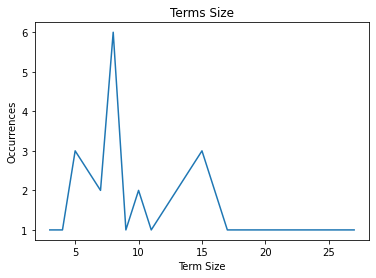

In [31]:
print("termos buscados")
searchedTerms = OutputHelper().selectVar(resultados,"searchTerm")
plotTermsSize(searchedTerms)

termos UMLS encontrados


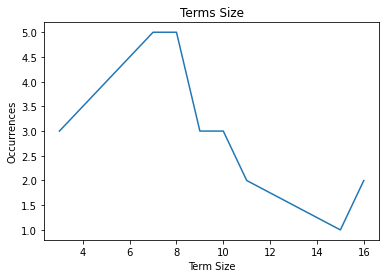

In [32]:
print("termos UMLS encontrados")
searchedTerms = OutputHelper().selectVar(resultados,"original")
plotTermsSize(searchedTerms)

termos SNOMED CT encontrados


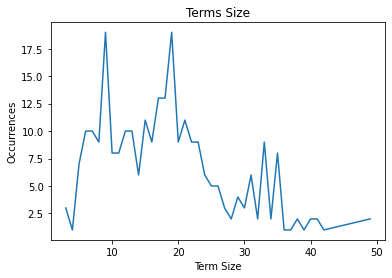

In [33]:
print("termos SNOMED CT encontrados")
searchedTerms = OutputHelper().selectVar(resultados,"STR")
plotTermsSize(searchedTerms)

### Tempos de execução

In [34]:
vars(temposExecucao[0].criaEstatistica(temposExecucao)[2])
#tempo total

{'R1': datetime.timedelta(seconds=2, microseconds=211642),
 'R2': datetime.timedelta(seconds=2, microseconds=68971),
 'R3': datetime.timedelta(seconds=1, microseconds=871163),
 'R4': datetime.timedelta(seconds=70, microseconds=749610),
 'R5': datetime.timedelta(seconds=6, microseconds=588674),
 'R6': datetime.timedelta(seconds=9, microseconds=309334),
 'R7': datetime.timedelta(0),
 'BUSCA': datetime.timedelta(seconds=3, microseconds=133091),
 'C12': datetime.timedelta(0),
 'C3': datetime.timedelta(microseconds=311139),
 'C4': datetime.timedelta(microseconds=587700)}

In [35]:
vars(temposExecucao[0].criaEstatistica(temposExecucao)[1])
#media #seconds

{'R1': 0.07898721428571429,
 'R2': 0.10889321052631579,
 'R3': 0.09848226315789473,
 'R4': 3.7236636842105266,
 'R5': 0.3467723157894737,
 'R6': 0.48996494736842106,
 'R7': None,
 'BUSCA': 0.16489952631578947,
 'C12': 0.0,
 'C3': 0.311139,
 'C4': 0.29385}

In [36]:
vars(temposExecucao[0].criaEstatistica(temposExecucao)[0])
#quantidade de chamadas

{'R1': 28,
 'R2': 19,
 'R3': 19,
 'R4': 19,
 'R5': 19,
 'R6': 19,
 'R7': 0,
 'BUSCA': 19,
 'C12': 16,
 'C3': 1,
 'C4': 2}